## MY CNN model

Test CNN model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
BATCH_SIZE = 16
# IMG_SIZE = (500,500)
# IMG_W = 500
# IMG_H = 500
IMG_SIZE = (300,300)
IMG_W = 300
IMG_H = 300
# IMG_SIZE = (400,518)
# IMG_W = 400
# IMG_H = 518

In [4]:
train_dataset = image_dataset_from_directory("../../data_earlystage/train/",
#                                             "../../data_grayscale_split/train/",
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 1011 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory("../../data_earlystage/val/",
#                                                   "../../data_grayscale_split/val/",
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 image_size=IMG_SIZE)

Found 245 files belonging to 2 classes.


In [6]:
class_names = train_dataset.class_names
class_names

['par1', 'wt']

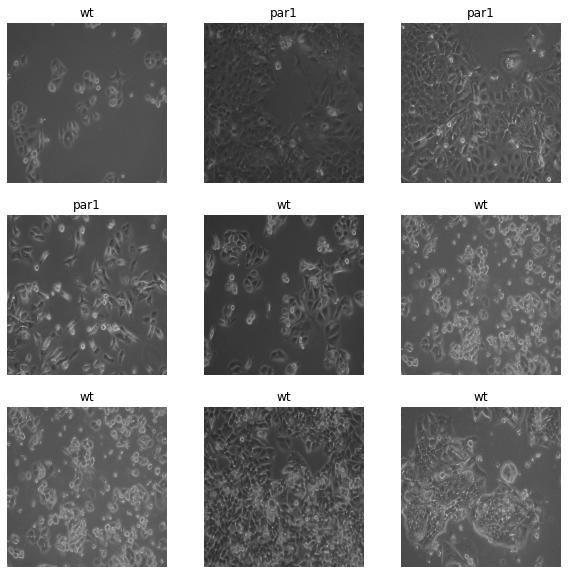

In [7]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
validation_dataset = validation_dataset.skip(val_batches//5)

In [9]:
print("Number of validation batches : %d" %tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches : %d" %tf.data.experimental.cardinality(test_dataset))

Number of validation batches : 13
Number of test batches : 3


In [10]:
AUTOTUNE =tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [41]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomCrop(round(IMG_W/2), round(IMG_H/2)),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5)) #newly added
])

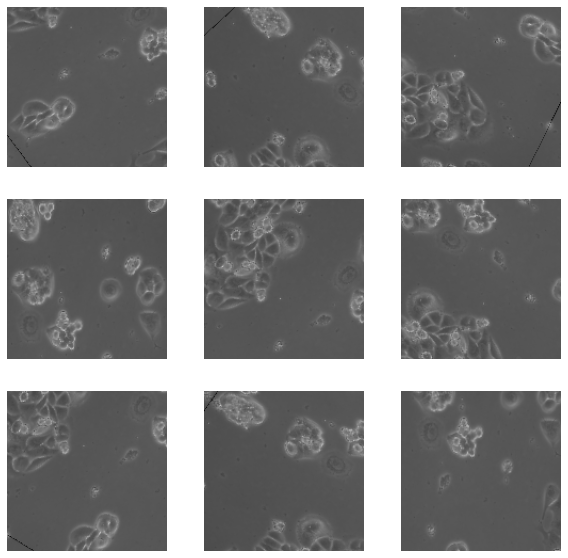

In [42]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [44]:
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)

rescale = Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_H, IMG_W),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)
])

In [61]:
drop_rate = 0.4 #looks it works better than 0.5

model = Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1, input_shape=(IMG_H, IMG_W,3)),
        data_augmentation,
        Conv2D(filters=32, kernel_size=(3,3), activation = 'relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(drop_rate),
        Flatten(),
        Dropout(drop_rate),
        Dense(units=128, activation='relu'),
        Dropout(drop_rate),
        Dense(units=128, activation='relu'),
#         Dense(units=1, activation='softmax')
        Dense(units=1, activation='relu')
    ])

In [62]:
base_lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr), 
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
# model.build(input_shape=(IMG_H, IMG_W,1))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 34, 34, 128)     

In [64]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

class TrainingCallback(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training ...")
    def on_train_end(self, logs=None):
        print("Finished training!")

early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, patience=30)

In [65]:
initial_epochs = 200
loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 1s 107ms/step - loss: 0.6931 - accuracy: 0.3147


In [66]:
print("initial loss : {:.2f}".format(loss0))
print("initial accuracy : {:.2f}".format(accuracy0))

initial loss : 0.69
initial accuracy : 0.31


In [67]:
history = model.fit(train_dataset,
                   epochs=initial_epochs,
                   validation_data=validation_dataset,
                   callbacks=[TrainingCallback(), early_stopping])

Starting training ...
Epoch 1/200
64/64 [==============================] - 16s 249ms/step - loss: 0.6404 - accuracy: 0.5529 - val_loss: 0.6410 - val_accuracy: 0.4670
Epoch 2/200
64/64 [==============================] - 14s 213ms/step - loss: 0.5689 - accuracy: 0.6588 - val_loss: 0.7169 - val_accuracy: 0.4365
Epoch 3/200
64/64 [==============================] - 14s 215ms/step - loss: 0.4723 - accuracy: 0.7616 - val_loss: 0.7031 - val_accuracy: 0.4416
Epoch 4/200
64/64 [==============================] - 14s 214ms/step - loss: 0.4566 - accuracy: 0.7636 - val_loss: 0.8032 - val_accuracy: 0.4619
Epoch 5/200
64/64 [==============================] - 14s 212ms/step - loss: 0.4485 - accuracy: 0.7705 - val_loss: 0.8317 - val_accuracy: 0.4518
Epoch 6/200
64/64 [==============================] - 14s 214ms/step - loss: 0.4398 - accuracy: 0.7834 - val_loss: 0.9227 - val_accuracy: 0.4213
Epoch 7/200
64/64 [==============================] - 14s 214ms/step - loss: 0.4343 - accuracy: 0.7804 - val_loss: 

64/64 [==============================] - 13s 209ms/step - loss: 0.3447 - accuracy: 0.8783 - val_loss: 1.0783 - val_accuracy: 0.5076
Epoch 58/200
64/64 [==============================] - 13s 210ms/step - loss: 0.3358 - accuracy: 0.8783 - val_loss: 1.0063 - val_accuracy: 0.5178
Epoch 59/200
64/64 [==============================] - 14s 213ms/step - loss: 0.3421 - accuracy: 0.8793 - val_loss: 0.7775 - val_accuracy: 0.5076
Epoch 60/200
64/64 [==============================] - 14s 213ms/step - loss: 0.3311 - accuracy: 0.8833 - val_loss: 0.8990 - val_accuracy: 0.5025
Epoch 61/200
64/64 [==============================] - 13s 206ms/step - loss: 0.3394 - accuracy: 0.8764 - val_loss: 0.9349 - val_accuracy: 0.5228
Epoch 62/200
64/64 [==============================] - 13s 210ms/step - loss: 0.3414 - accuracy: 0.8694 - val_loss: 0.9698 - val_accuracy: 0.5076
Epoch 63/200
64/64 [==============================] - 14s 217ms/step - loss: 0.3386 - accuracy: 0.8813 - val_loss: 0.8703 - val_accuracy: 0.522

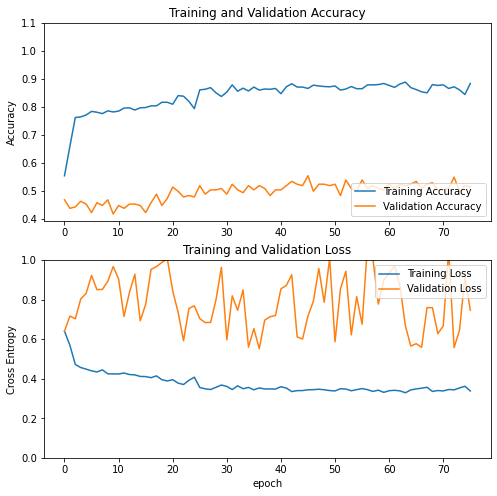

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [334]:
# import pickle
# with open("./cnn_model_test00",'wb') as file_pi:
#     pickle.dump(history_fine.history, file_pi)

In [335]:
# test_load = pickle.load(open("./cnn_model_test00",'rb'))
# test_load['loss']